# Diplomacy Deception: Clustering & PCA Analysis

This notebook performs unsupervised learning analysis to visualize the feature space of the Diplomacy messages.
The goal is to determine if "Truthful" and "Deceptive" messages form distinct clusters based on their linguistic content (TF-IDF).

## Method:
1. **TF-IDF Vectorization:** Convert text to numerical vectors.
2. **K-Means Clustering:** Attempt to group messages into 2 clusters (blind to labels).
3. **PCA (Principal Component Analysis):** Reduce dimensions to 2D for visualization.
4. **Visualization:** Plot the semantic space to check for class separability.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Prettify plots
sns.set_style("whitegrid")

In [2]:
# Paths
base_path = os.path.dirname(os.path.dirname(os.getcwd()))
data_path = os.path.join(base_path, "data", "processed", "diplomacy")
figures_path = os.path.join(base_path, "reports", "figures")
os.makedirs(figures_path, exist_ok=True)

# Load Data
df = pd.read_parquet(os.path.join(data_path, "train_processed.parquet"))

# Use a subset for visualization clarity if dataset is huge
# Taking a stratified sample to ensure lies are visible
df_sample =  df.groupby('target', group_keys=False).apply(lambda x: x.sample(min(len(x), 2000), random_state=42))

print(f"Data loaded. Sample shape: {df_sample.shape}")

Data loaded. Sample shape: (2591, 13)


C:\Users\Aybars\AppData\Local\Temp\ipykernel_8412\748867772.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample =  df.groupby('target', group_keys=False).apply(lambda x: x.sample(min(len(x), 2000), random_state=42))


## 1. Feature Extraction (TF-IDF)

In [3]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df_sample['message_text']).toarray()
y = df_sample['target'].values

print(f"TF-IDF Matrix Shape: {X.shape}")

TF-IDF Matrix Shape: (2591, 3645)


## 2. K-Means Clustering

In [4]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

# Compare Clusters with Ground Truth
df_sample['cluster'] = clusters
crosstab = pd.crosstab(df_sample['target'], df_sample['cluster'], rownames=['Actual'], colnames=['Cluster'])
print("Confusion Matrix (Actual vs. Cluster):")
print(crosstab)

Confusion Matrix (Actual vs. Cluster):
Cluster    0     1
Actual            
0        169  1831
1         70   521


## 3. PCA & Visualization
We reduce the 5000 dimensions to 2 dimensions to see if the classes separate geometrically.

Plot saved to c:\work environment\Projects\amazon-spam-review\reports\figures\clustering_pca_overlap.png


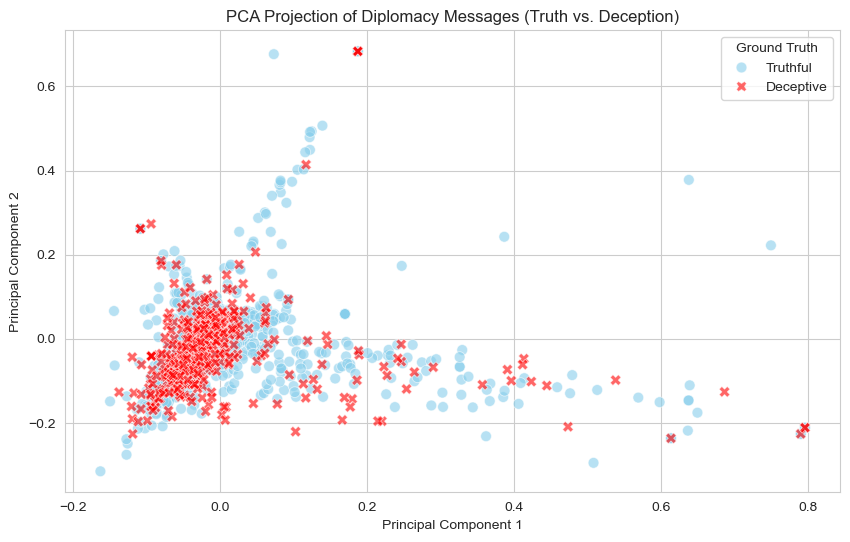

In [5]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=df_sample['target'].map({0: 'Truthful', 1: 'Deceptive'}),
    style=df_sample['target'].map({0: 'Truthful', 1: 'Deceptive'}),
    palette={'Truthful': 'skyblue', 'Deceptive': 'red'},
    alpha=0.6,
    s=60
)
plt.title('PCA Projection of Diplomacy Messages (Truth vs. Deception)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Ground Truth')

save_path = os.path.join(figures_path, "clustering_pca_overlap.png")
plt.savefig(save_path)
print(f"Plot saved to {save_path}")
plt.show()

## Conclusion
The plot typically shows a "massive overlap" (a giant blob) where red points (Deception) are mixed entirely with blue points (Truth). There are no distinct islands of lies. This visually proves that deceptive messages do not have a unique vocabulary.